# AMIA 2016 Annual Symposium Workshop (WG13)

## Automated and Scalable Cloud-based RNA-Seq Data Analysis, Part III


Riyue Bao, Ph.D. 
Center for Research Informatics,
The University of Chicago.
November 13, 2016

***

## Objective

* Learn the downstream analysis of RNAseq data
    * Detect genes differentially expressed between conditions
    * Generate high-quality figures for publication (PCA, volcano, heatmap, sample/gene cluster, etc.)
    * Identify pathways / network enriched in genes of interest
* Practice the workflow interactively

***

## Dataset

The test datasets used in this workshop are from 
Fog. et al. 2015. Loss of PRDM11 promotes MYC-driven lymphomagenesis. Blood, 125(8):1272-81
<http://www.bloodjournal.org/content/125/8/1272.long?sso-checked=true>

***

## Identify DEGs: DESeq2

Commonly used tool / package for detection of signficant DEGs include `DESeq2`, `limma/limmavoom`, `edgeR`, etc.

For this workshop, We will demo how to use DESeq2 to detect DEGs between WT and KO groups.

***

### Clean the environment


In [1]:
rm(list=ls())

### Load libraries / packages

In [2]:
##-- List packages required in this analysis
cpan.pkg.list = c('ggplot2', 'scales', 'ape', 'RColorBrewer', 
                  'reshape','VennDiagram')
bioc.pkg.list = c('ctc',  'limma', 'edgeR', 'DESeq2', 'vsn', 
                  'genefilter', 'pheatmap', 
                  'clusterProfiler', 'pathview',
                  'AnnotationHub')

##-- Set up CPAN repo (required if running IRkernel in Jupyter)
# cpan.repos = 'http://cran.us.r-project.org'

##-- Install CPAN packages
# install.packages('ggplot2', repos=cpan.repos) 
# lapply(cpan.pkg.list, suppressMessages(install.packages), 
#        repos=cpan.repos, character.only = TRUE)

##-- Set up Bioconductor repo
# source("http://bioconductor.org/biocLite.R")

##-- Install Bioc packages
# biocLite('DESeq2')
# lapply(bioc.pkg.list, suppressMessages(biocLite), 
#        character.only = TRUE)

##-- Load libraries
for(pkg in c(cpan.pkg.list, bioc.pkg.list)) {
    print(pkg)
    suppressMessages(require(pkg, character.only = TRUE))
}

##-- replace Hs with other (e.g. Mm) if you work on other species
##-- annotation database used by clusterProfiler
# suppressMessages(library(org.Hs.eg.db))

[1] "ggplot2"
[1] "scales"
[1] "ape"
[1] "RColorBrewer"
[1] "reshape"
[1] "VennDiagram"
[1] "ctc"
[1] "limma"
[1] "edgeR"
[1] "DESeq2"


Warning message:
: replacing previous import by 'ggplot2::Position' when loading 'DESeq2'

[1] "vsn"
[1] "genefilter"
[1] "pheatmap"
[1] "clusterProfiler"
[1] "pathview"
[1] "AnnotationHub"


### Set up global parameters, input/output directories and files

In [3]:
##-- Parameters
cancer = 'DLBC' 
fdr = 0.05
fc = 1.5
gene.type = 'coding'
caller = 'deseq2'
group1 = 'KO'
group2 = 'WT'
colors = c('#CC0000', '#00CC00')

##-- Set up working directory
work.dir = '.'
setwd(work.dir)

##-- Input/Output directories
in.dir = 'input'
out.dir = 'output'

##-- Input/Output files
expr.file = paste0(cancer, '.raw_counts.txt')
sample.file = paste0(cancer, '.sample_group.txt')
geneinfo.file = 'gencode.v24.primary_assembly.annotation.gtf.geneinfo'

### Print analysis info

In [4]:
print(paste0('Cancer = ', cancer))
print(paste0('gene type = ', gene.type))
print(paste0('DEG fdr cutoff = ', fdr))
print(paste0('DEG fc cutoff = ', fc))
print(paste0('Expression file = ', expr.file))
print(paste0('Sample group file  = ', sample.file))
print(paste0('Gene info file  = ', geneinfo.file))

[1] "Cancer = DLBC"
[1] "gene type = coding"
[1] "DEG fdr cutoff = 0.05"
[1] "DEG fc cutoff = 1.5"
[1] "Expression file = DLBC.raw_counts.txt"
[1] "Sample group file  = DLBC.sample_group.txt"
[1] "Gene info file  = gencode.v24.primary_assembly.annotation.gtf.geneinfo"


### Import data files

In [5]:
##-- Read data files 
data.expr = read.delim(paste0(in.dir, '/', expr.file),
                       header=T, stringsAsFactors=F)
data.sample = read.delim(paste0(in.dir, '/', sample.file),
                         header=T, stringsAsFactors=F)
data.geneinfo = read.delim(paste0(in.dir, '/', geneinfo.file), 
                           header = T, stringsAsFactors = F)

### Peek into imported data

In [6]:
##-- Expression matrix: raw read counts
print(paste0('Expression matrix = ', 
             nrow(data.expr), ' genes, ', 
             ncol(data.expr), ' fields'))
data.expr[1:3,]

##-- Sample table: experimental design & groups
print(paste0('Sample table = ', 
             nrow(data.sample), ' samples, ', 
             length(table(data.sample$Group)), ' groups'))
data.sample

##-- Gene annotation 
print(paste0('Gene annotation = ', 
             nrow(data.geneinfo), ' genes, ', 
             ncol(data.geneinfo), ' fields'))
head(data.geneinfo)

[1] "Expression matrix = 60725 genes, 12 fields"


,Geneid,Chr,Start,End,Strand,Length,KO01,KO02,KO03,WT01,WT02,WT03
1,ENSG00000223972.5,chr1;chr1;chr1;chr1,11869;12613;12975;13221,12227;12721;13052;14409,+;+;+;+,1735,1,1,0,1,0,0
2,ENSG00000227232.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,14404;15005;15796;16607;16858;17233;17606;17915;18268;24738;29534,14501;15038;15947;16765;17055;17368;17742;18061;18366;24891;29570,-;-;-;-;-;-;-;-;-;-;-,1351,2,3,0,2,6,3
3,ENSG00000278267.1,chr1,17369,17436,-,68,0,0,0,0,0,0


[1] "Sample table = 6 samples, 2 groups"


,Sample,Group
1,KO01,KO
2,KO02,KO
3,KO03,KO
4,WT01,WT
5,WT02,WT
6,WT03,WT


[1] "Gene annotation = 60725 genes, 6 fields"


,gene_id,gene_type,gene_status,gene_name,level,havana_gene
1,ENSG00000000003.14,protein_coding,KNOWN,TSPAN6,2,OTTHUMG00000022002.1
2,ENSG00000000005.5,protein_coding,KNOWN,TNMD,2,OTTHUMG00000022001.1
3,ENSG00000000419.12,protein_coding,KNOWN,DPM1,2,OTTHUMG00000032742.2
4,ENSG00000000457.13,protein_coding,KNOWN,SCYL3,2,OTTHUMG00000035941.5
5,ENSG00000000460.16,protein_coding,KNOWN,C1orf112,2,OTTHUMG00000035821.7
6,ENSG00000000938.12,protein_coding,KNOWN,FGR,2,OTTHUMG00000003516.2


### Preprocess data: Expression matrix, Gene annotation

In [7]:
data.expr.proc = data.expr
data.sample.proc = data.sample
data.geneinfo.proc = data.geneinfo

##-- Set up row names of each data frame
row.names(data.expr.proc) = data.expr.proc[,1]
row.names(data.sample.proc) = data.sample.proc[,1]
row.names(data.geneinfo.proc) = data.geneinfo.proc[,1]

##-- Expression matrix: remove extra columns 
# colnames(data.expr.proc)
data.expr.proc = data.expr.proc[,c(1,7:12)]
colnames(data.expr.proc)[1] = 'Gene'

##-- Expression matrix: add gene symbol to Ensembl geneid 
##-- from annotation
print(sum(data.expr.proc$Gene %in% data.geneinfo.proc$gene_id) 
      == nrow(data.expr.proc))
data.expr.proc = merge(data.geneinfo.proc[,c('gene_id', 
                                             'gene_name')], 
                       data.expr.proc, by = 'row.names')

##-- Expression matrix: concat gene symbol & Ensembl id 
##-- as unique key for each gene row
data.expr.proc$Gene = paste0(data.expr.proc$gene_name, 
                             '!', data.expr.proc$gene_id)
data.expr.proc = data.expr.proc[,-c(1:3)]
row.names(data.expr.proc) = data.expr.proc[,1]
data.expr.proc = data.expr.proc[,-1]

##-- Expression matrix: peek into preprocessed data
data.expr.proc[1:3,]

##-- Gene annotation: show gene types
data.frame(table(data.geneinfo.proc$gene_type))

##-- Gene annotation: retrieve Ensembl id only
data.geneinfo.proc.gene = data.geneinfo.proc[,c(1,2,4)]
data.geneinfo.proc.gene = unique(data.geneinfo.proc.gene)
print(paste0('Total genes = ', nrow(data.geneinfo.proc.gene)))

##-- Gene annotation: concat gene symbol & Ensembl id
##-- as unique key for each gene row
data.geneinfo.proc.gene = data.frame(Key = 
                    paste0(data.geneinfo.proc.gene$gene_name,'!',
                           data.geneinfo.proc.gene$gene_id), 
                                     data.geneinfo.proc.gene)
row.names(data.geneinfo.proc.gene) = data.geneinfo.proc.gene[,1]
data.geneinfo.proc = data.geneinfo.proc[,-1]

##-- Gene annotation: keep two types of genes, 
##-- coding and lincRNA, for further analysis
gene.coding = data.geneinfo.proc.gene[
    data.geneinfo.proc.gene$gene_type == 'protein_coding',]
gene.lincrna = data.geneinfo.proc[
    data.geneinfo.proc.gene$gene_type == 'lincRNA',]

##-- Gene annotation: show how many genes are in each list
print(paste0('Coding genes = ', nrow(gene.coding)))
print(paste0('lincRNA genes = ', nrow(gene.lincrna)))

[1] TRUE


,KO01,KO02,KO03,WT01,WT02,WT03
TSPAN6!ENSG00000000003.14,3,1,4,0,0,0
TNMD!ENSG00000000005.5,0,0,0,0,0,0
DPM1!ENSG00000000419.12,3197,2318,1356,2630,2735,2721


,Var1,Freq
1,3prime_overlapping_ncrna,29
2,antisense,5564
3,bidirectional_promoter_lncrna,3
4,IG_C_gene,14
5,IG_C_pseudogene,9
6,IG_D_gene,37
7,IG_J_gene,18
8,IG_J_pseudogene,3
9,IG_V_gene,145
10,IG_V_pseudogene,183


[1] "Total genes = 60725"
[1] "Coding genes = 19844"
[1] "lincRNA genes = 7674"


### Proior to DEG identification: Subset expression matrix based on gene type

In [8]:
data.sample.proc.sub = data.sample.proc

##-- Expression matrix: select gene rows 
##-- based on specified gene type (coding or lincrna)
gene.list = ''
if(gene.type == 'coding') { gene.list = gene.coding  }
if(gene.type == 'lincrna') { gene.list = gene.lincrna }
data.expr.proc.sub = data.expr.proc[
    row.names(data.expr.proc) %in% row.names(gene.list),] 

##-- Expression matrix: sort matrix sample column 
##-- to be consistent with sample table 
##--(required for DEG analysis)
data.expr.proc.sub = data.expr.proc.sub[,data.sample.proc.sub$Sample] 

print(paste0('Gene list = ', 
             nrow(gene.list), ' (', gene.type, ')'))
print(paste0('Expression matrix before subsetting: ', 
             nrow(data.expr.proc), ' genes'))
print(paste0('Expression matrix after subsetting: ', 
             nrow(data.expr.proc.sub), ' genes'))

[1] "Gene list = 19844 (coding)"
[1] "Expression matrix before subsetting: 60725 genes"
[1] "Expression matrix after subsetting: 19844 genes"


### Identify DEGs: DESeq2

In [9]:
out.prefix = paste0(out.dir, '/', caller, '/',cancer,'.',
                    gene.type, '.', caller)

##-- DESeq2: note data.sample.proc.sub must 
##-- have the same sample column
##-- order as data.expr.proc.sub
Group = as.factor(data.sample.proc.sub$Group)

##-- DESeq2: covert to matrix data format (previously was data frame)
cds = as.matrix(data.expr.proc.sub)

##-- DESeq2: build DESeqDataSet object, prepare design matrix
dds = DESeqDataSetFromMatrix(countData = cds,
                           colData = data.sample.proc.sub, 
                           design = ~ Group)

##-- DESeq2: note this is just simple filter to reduce mem
##-- no affect on DEG results
# dim(dds)
# dds = dds[ rowSums(counts(dds)) > 0, ]
# dim(dds)

##-- DESeq2: plot estimated dispersions
# pdf(paste0(out.prefix, '.dispersion.pdf'),width = 7, height = 7)
# plotDispEsts(dds, xlim = c(1,10000), ylim = c(1E-10, 1))
# dev.off()

print(dds)

Warning message:
In DESeqDataSet(se, design = design, ignoreRank): some variables in design formula are characters, converting to factors

class: DESeqDataSet 
dim: 19844 6 
exptData(0):
assays(1): counts
rownames(19844): TSPAN6!ENSG00000000003.14 TNMD!ENSG00000000005.5 ...
  CRLF2!ENSGR0000205755.11 ZBED1!ENSGR0000214717.10
rowData metadata column names(0):
colnames(6): KO01 KO02 ... WT02 WT03
colData names(2): Sample Group


### DESeq2: Normalize and log2-transform count matrix for heatmap, sample clustering, etc. (NOT for DEG identification)

In [10]:
##-- DESeq2: three normalization algrithms (rld, vsd and vsd.fast)
rld = rlog(dds, blind=FALSE)
vsd = varianceStabilizingTransformation(dds, blind=FALSE)
# vsd.fast = vst(dds, blind=FALSE)

##-- DESeq2: peek into normalized expression matrix
head(assay(rld), 3)
head(assay(vsd), 3)

##-- DESeq2: print normalized expression matrix to local files
write.table(data.frame(Gene = row.names(assay(rld)), assay(rld)),
          file = paste0(out.prefix, '.rld.txt'),
          sep = '\t', col.names = T, row.names = F, quote = F)

write.table(data.frame(Gene = row.names(assay(vsd)), assay(vsd)),
          file = paste0(out.prefix, '.vsd.txt'),
          sep = '\t', col.names = T, row.names = F, quote = F)

,KO01,KO02,KO03,WT01,WT02,WT03
TSPAN6!ENSG00000000003.14,0.4730110,0.4585560,0.4934025,0.4498322,0.4493510,0.4491687
TNMD!ENSG00000000005.5,0,0,0,0,0,0
DPM1!ENSG00000000419.12,11.32573,11.17868,10.95445,11.36665,11.30636,11.26410


,KO01,KO02,KO03,WT01,WT02,WT03
TSPAN6!ENSG00000000003.14,6.638286,6.545740,6.749040,6.389882,6.389882,6.389882
TNMD!ENSG00000000005.5,6.389882,6.389882,6.389882,6.389882,6.389882,6.389882
DPM1!ENSG00000000419.12,11.46204,11.25011,10.91816,11.52110,11.43448,11.37366


### DESeq2: plot mean to var to confirm variance shrink works 

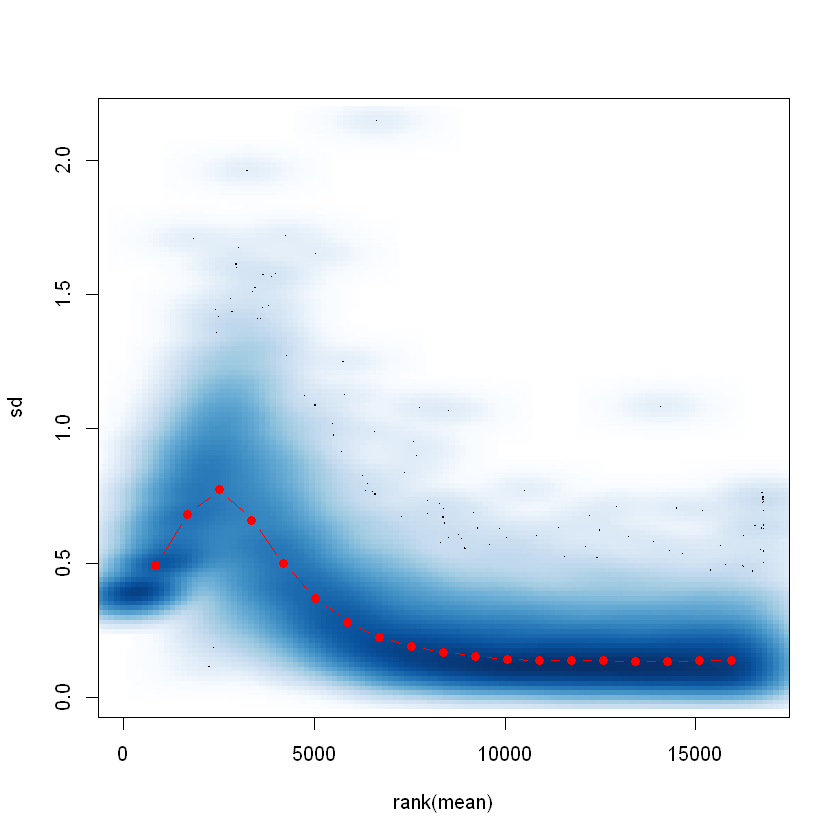

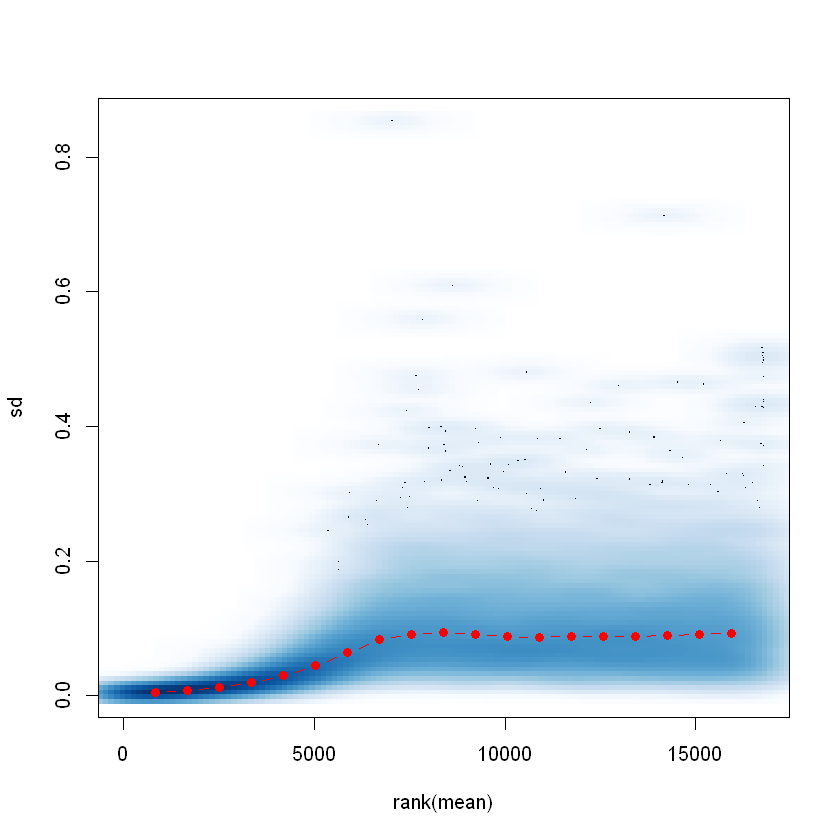

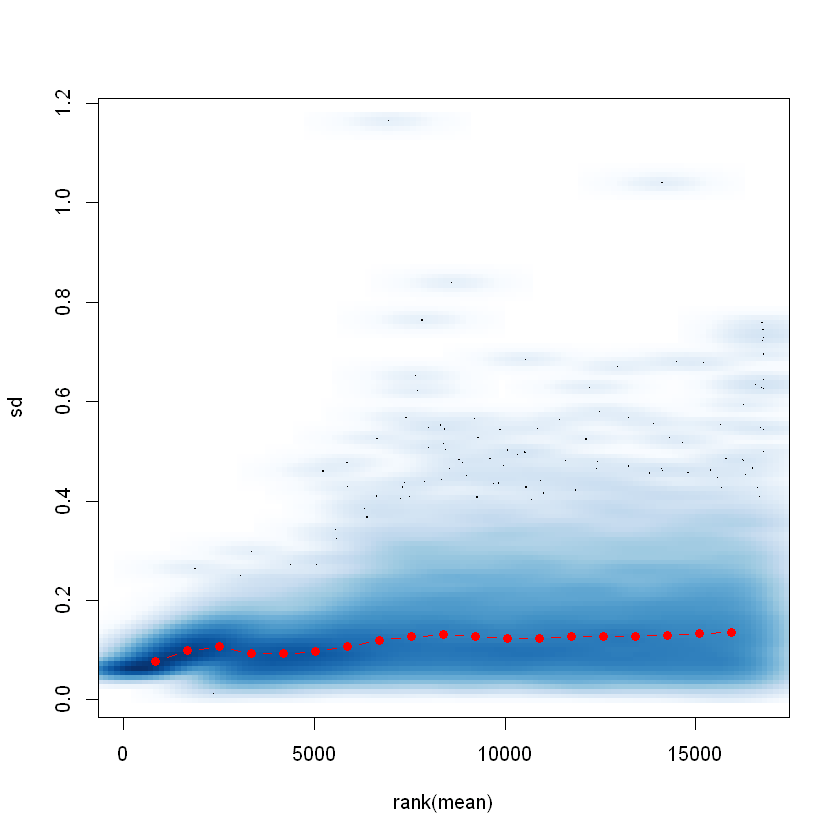

In [11]:
##-- DESeq2: remove genes not expressed in any samples
##-- for plottig purposes
notAllZero = (rowSums(counts(dds))>0)

##-- DESeq2: mean to var plots 
# pdf(paste0(out.prefix, '.meanvar.log2.pdf'),width = 7, height = 7)
meanSdPlot(log2(counts(estimateSizeFactors(dds),
                       normalized=TRUE)[notAllZero,] + 1))
# dev.off()

# pdf(paste0(out.prefix, '.meanvar.rld.pdf'),width = 7, height = 7)
meanSdPlot(assay(rld[notAllZero,]))
# dev.off()

# pdf(paste0(out.prefix, '.meanvar.vsd.pdf'),width = 7, height = 7)
meanSdPlot(assay(vsd[notAllZero,]))
# dev.off()

### DESeq2: Quality assessment of sample-to-sample relationships (correlation heatmap & PCA)

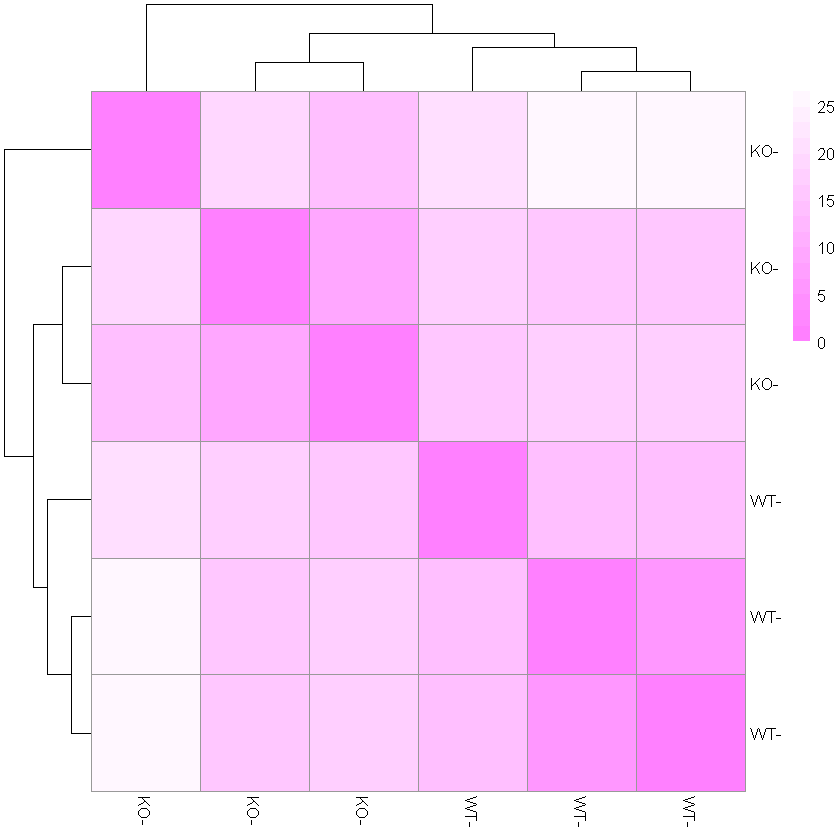

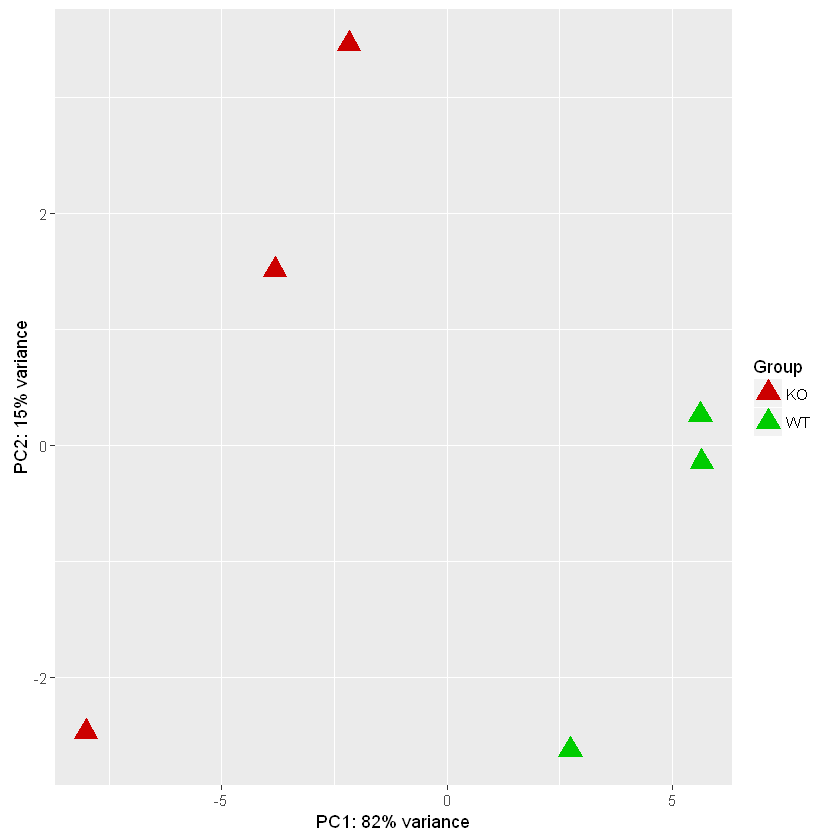

In [12]:
##-- DESeq2: sample correlation heatmap
##-- calculate sample distance 
sampleDists = dist(t(assay(rld)))
sampleDistMatrix = as.matrix(sampleDists)
rownames(sampleDistMatrix) = paste(rld$Group, rld$Libtype, sep="-")
colnames(sampleDistMatrix) = rownames(sampleDistMatrix)

##-- DESeq2: plot heatmap
heatmap.colors = rev(cm.colors(32))[1:16]
# pdf(paste0(out.prefix, '.sm_cor.pdf'),width = 7, height = 7)
pheatmap(sampleDistMatrix,
       clustering_distance_rows=sampleDists,
       clustering_distance_cols=sampleDists,
       col=heatmap.colors)
# dev.off()

##-- DESeq2: Principal component analysis (PCA) plot of the samples
##-- use ggplot2 to customize the PCA plot
# pdf(paste0(out.prefix, '.pca.pdf'),width = 7, height = 7)
data.pca = plotPCA(rld, intgroup=c('Group'), returnData=TRUE)
percent.var = round(100 * attr(data.pca, "percentVar"))
pca.colors = c(KO = colors[1], WT = colors[2])
p1 = ggplot(data.pca, aes(PC1, PC2, color = Group)) +
            geom_point(size = 5, shape = 17) +
            scale_colour_manual(values = pca.colors) + 
            xlab(paste0("PC1: ",percent.var[1],"% variance")) +
            ylab(paste0("PC2: ",percent.var[2],"% variance"))
plot(p1)

### DESeq2: identify DEG between groups

[1] "Group 1 = KO"
[1] "Group 2 = WT"


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing



out of 16790 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 1414, 8.4% 
LFC < 0 (down)   : 1409, 8.4% 
outliers [1]     : 84, 0.5% 
low counts [2]   : 4988, 30% 
(mean count < 22.5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "mean of normalized counts for all samples"
[2] "log2 fold change (MAP): Group KO vs WT"   
[3] "standard error: Group KO vs WT"           
[4] "Wald statistic: Group KO vs WT"           
[5] "Wald test p-value: Group KO vs WT"        
[6] "fdr adjusted p-values"

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,foldChange
TSPAN6!ENSG00000000003.14,TSPAN6!ENSG00000000003.14,1.449331,0.1711304,0.08773687,1.950495,0.0511171,NA,1.12594
TNMD!ENSG00000000005.5,TNMD!ENSG00000000005.5,0,NA,NA,NA,NA,NA,NA
DPM1!ENSG00000000419.12,DPM1!ENSG00000000419.12,2427.049,-0.2019446,0.1244295,-1.622963,0.1045972,0.2655265,-1.150248


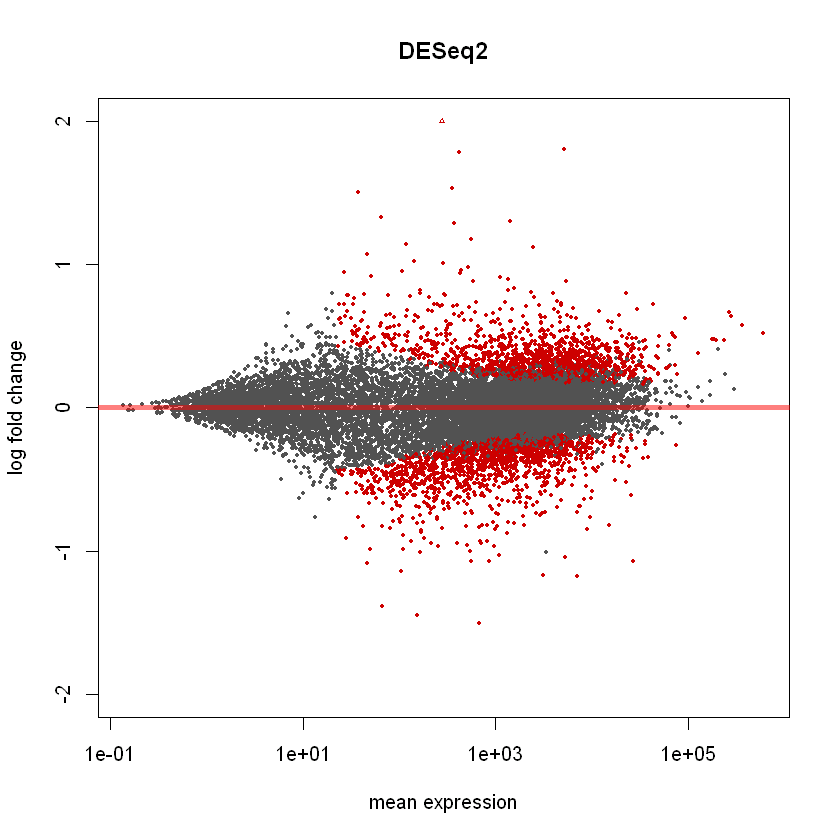

In [13]:
print(paste0('Group 1 = ', group1))
print(paste0('Group 2 = ', group2))

comp = paste0(group1, 'vs', group2, '.')
out.prefix = paste0(out.dir, '/', caller,'/',cancer,'.',
                    gene.type, '.',comp,caller,'.txt')

##-- DESeq2: fit the model and identify DEGs
##-- same as running those three steps: 
##-- (1) dds = estimateSizeFactors(dds)
##-- (2) dds = estimateDispersions(dds)
##-- (3) dds = nbinomWaldTest(dds)
dds = DESeq(dds, test="Wald", betaPrior=T)
res = results(dds, 
              contrast=c("Group",group1,group2), 
              pAdjustMethod ="fdr", 
              alpha=fdr)

##-- DESeq2: save the result as an R object for reloading
##-- in future analysis
# save(res, file = paste0(out.prefix,'.RData'))

##-- DESeq2: Plot MA to display differential expression 
##-- versus expression strength
# pdf(paste0(out.prefix,'.MAplot.pdf'), width=7, height=7)
plotMA(res, main="DESeq2", ylim=c(-2,2))
# dev.off()

##-- DESeq2: peek into DEG data object
summary(res)
mcols(res)$description
res = as.data.frame(res)

##-- DESeq2: add fold change (via anti-log log2FC)
res$foldChange = NA
row_pos = which(! is.na(res$log2FoldChange) & 
                res$log2FoldChange >= 0)
row_neg = which(! is.na(res$log2FoldChange) & 
                res$log2FoldChange < 0)
res$foldChange[row_pos] = 2^res$log2FoldChange[row_pos]
res$foldChange[row_neg] = -2^((-1) * res$log2FoldChange[row_neg])
res = data.frame(id = row.names(res), res)
# print(sum(res$foldChange == 0) == 0)

##-- DESeq2: peek into gene list
res[1:3,]

##-- DESeq2: save DEG output into local file
res.ensembl = gsub('\\S+[!]', '', res[,1], perl = T)
res.symbol = gsub('[!]\\S+', '', res[,1], perl = T)
res.print = data.frame(ENSEMBL = res.ensembl,
                       SYMBOL = res.symbol,
                        res[,-c(1:2)])
write.table(res.print,
          file = out.prefix,
          sep = '\t', col.names = T, row.names = F, quote = F)

### DESeq2: Filter for significant DEGs by fold change and fdr 

[1] "Genes removed = 8126 (fold change is NA)"
[1] "Genes kept = 11718"
[1] "Filter DEGs by: fc, 1.5, fdr 0.05"
[1] "Genes filtered = 11427 (fc, 1.5, fdr 0.05)"
[1] "Genes kept = 291"


,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,foldChange
SPATA20!ENSG00000006282.20,SPATA20!ENSG00000006282.20,339.1868,-0.6136447,0.1142878,-5.369291,7.904659e-08,4.135125e-06,-1.53012
MYLIP!ENSG00000007944.14,MYLIP!ENSG00000007944.14,498.9798,-0.82567,0.1083236,-7.622254,2.492846e-14,6.08566e-12,-1.772358
SNAI2!ENSG00000019549.8,SNAI2!ENSG00000019549.8,143.4191,0.6023509,0.1526711,3.945416,7.966161e-05,0.001384977,1.518188


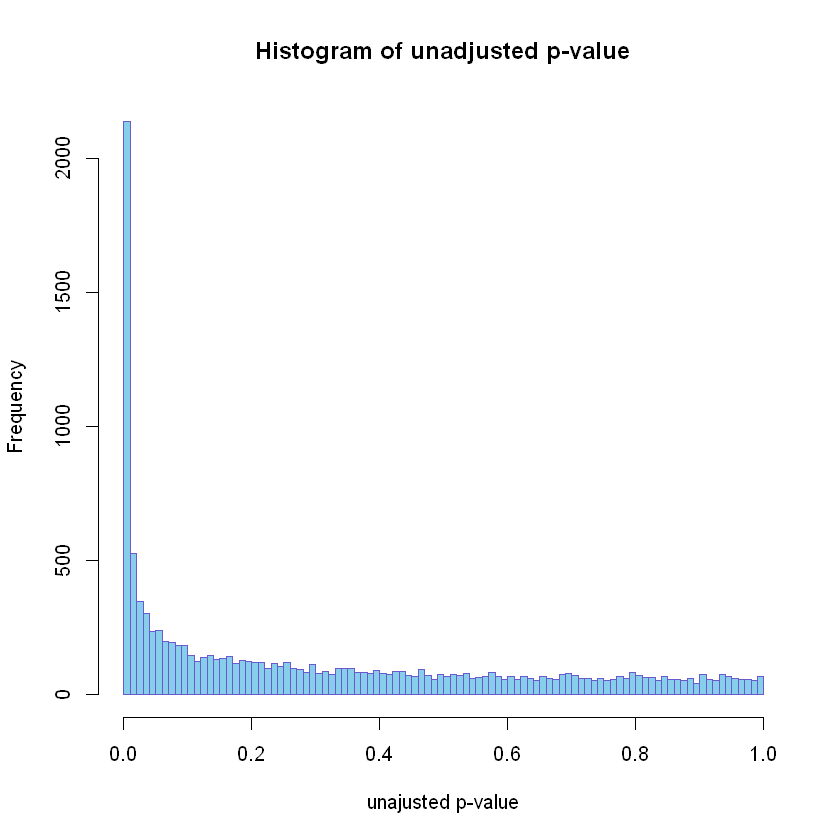

In [14]:
##-- DESeq2: remove nan values for the foldchange == NAN
before = nrow(res)
res = res[!is.na(res$foldChange) & ! is.na(res$padj),];
after = nrow(res)
print(paste0('Genes removed = ', (before - after), 
             ' (fold change is NA)'))
print(paste0('Genes kept = ', after))

print(paste0('Filter DEGs by: fc, ', fc, ', fdr ', fdr))

##-- DESeq2: plot histogram of unadj p-value for sanity check
# pdf(paste0(out.prefix,'.pvalue.hist.pdf'), width=7, height=7)
hist(res$pval, breaks=100, 
     col="skyblue", border="slateblue", 
     main="Histogram of unadjusted p-value", 
     xlab="unajusted p-value") 
# dev.off()   

##-- DESeq2: filter DEGs
res.flt = res[(res$foldChange >= fc | res$foldChange <= -fc) & 
              res$padj < fdr,]
print(paste0('Genes filtered = ', (after - nrow(res.flt)), 
             ' (fc, ', fc, ', fdr ', fdr, ')'))
print(paste0('Genes kept = ', nrow(res.flt)))

##-- DESeq2: peek into filtered gene list
res.flt[1:3,]

##-- DESeq2: save filtered DEG output into local file
if(nrow(res.flt) > 0) {
    res.flt.ensembl = gsub('\\S+[!]', '', res.flt[,1], perl = T)
    res.flt.print = res.print[res.print$ENSEMBL %in% res.flt.ensembl,]
    write.table(res.flt.print, paste0(out.prefix, 
                                '.flt.fdr', fdr, '_fc', fc), 
                col.names=T, row.names=F, sep='\t', quote=F)
}

### DESeq2: Plot expression heatmap of significant DEGs

[1] "Genes significant = 291 (fc, 1.5, fdr 0.05)"
[1] "Heatmap = 291 genes on the row, 6 samples on the column"


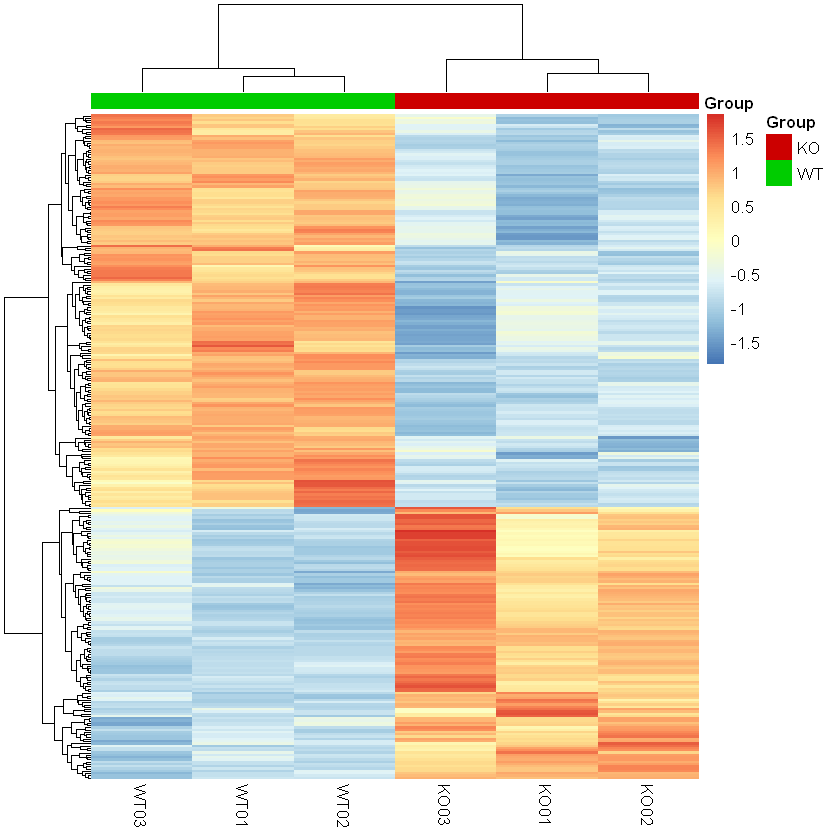

In [15]:
##-- DESeq2: continue with significant DEGs from previous step
print(paste0('Genes significant = ', nrow(res.flt), 
             ' (fc, ', fc, ', fdr ', fdr, ')'))

##-- DESeq2: select those sig genes from normalized expression matrix
gene.select = res.flt$id
data.plot = assay(rld)
data.plot = data.plot[row.names(data.plot) %in% gene.select,,
                      drop = FALSE]

##-- DESeq2: prepare annotation label and colors
data.plot.anno = as.data.frame(
    data.sample.proc.sub[,colnames(data.sample.proc.sub) %in%
                         c('Group'),
                         drop = FALSE])
data.plot.anno.colors = list(Group = c(KO = colors[1], WT = colors[2]))

##-- DESeq2: plot sig DEG heatmap
print(paste0('Heatmap = ', nrow(data.plot), ' genes on the row, ', 
             ncol(data.plot), ' samples on the column'))
pheatmap(data.plot,
         scale = 'row',
         cluster_rows = TRUE, cluster_cols = TRUE,
         show_rownames = FALSE, show_colnames = TRUE,
         clustering_distance_rows = "euclidean",
         clustering_distance_cols = "euclidean", 
         clustering_method = "complete",
         annotation_row = NA, 
         annotation_col = data.plot.anno,
         annotation_colors = data.plot.anno.colors
        )

### clusterProfiler: Prepare input for GO/KEGG enrichment analysis

In [16]:
##-- clusterProfiler: prepare input for GO/KEGG enrichment analysis
genes.all = res.print
genes.sig = res.flt.print
genes.all$ENSEMBL = gsub('[.]\\d+', '', genes.all$ENSEMBL, perl = T)
genes.sig$ENSEMBL = gsub('[.]\\d+', '', genes.sig$ENSEMBL, perl = T)

##-- clusterProfiler: remove genes with fc / pvalue as NA
genes.all = na.omit(genes.all)

# ##--clusterProfiler: add EntrezID
# # keytypes(org.Hs.eg.db)
# # [1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS" "ENTREZID"    
# # [7] "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"     "GO"           "GOALL"       
# # [13] "IPI"          "MGI"          "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"        
# # [19] "PMID"         "PROSITE"      "REFSEQ"       "SYMBOL"       "UNIGENE"      "UNIPROT"  
# genes.all.anno = bitr(genes.all$ENSEMBL, fromType='ENSEMBL', 
#                       toType=c('ENTREZID', 'SYMBOL'), 
#                       annoDb='org.Mm.eg.db', drop = T)

# ##-- clusterProfiler: remove genes with duplicate EntrezIDs
# genes.all.anno = genes.all.anno[
#     which(! duplicated(genes.all.anno$ENTREZID)), ]
# row.names(genes.all.anno) = genes.all.anno$ENTREZID

# ##-- clusterProfiler: add fc and p-value to genes.all.anno
# genes.all.anno = merge(genes.all.anno, genes.all, by = 'ENSEMBL')
genes.all.anno = read.delim(paste0(out.prefix,'.anno'), 
                           header = T, stringsAsFactors = F)
row.names(genes.all.anno) = genes.all.anno$ENTREZID

##-- clusterProfiler: prepare significant gene list
genes.sig.anno = genes.all.anno[genes.all.anno$ENSEMBL %in% 
                                genes.sig$ENSEMBL,]

print(paste0('Genes significant = ', nrow(genes.sig.anno)))
genes.sig.anno[1:3,1:7]

##-- clusterProfiler: prepare input for GSEA 
##-- ranked gene list with decreasing fold change
gene.list = genes.all.anno$foldChange
names(gene.list) = genes.all.anno$ENTREZID
gene.list = sort(gene.list, decreasing = T)
gene.list[1:3]

[1] "Genes significant = 289"


,ENSEMBL,ENTREZID,SYMBOL,GENENAME,log2FoldChange,lfcSE,stat
64847,ENSG00000006282,64847,SPATA20,spermatogenesis associated 20,-0.6136447,0.1142878,-5.369291
29116,ENSG00000007944,29116,MYLIP,myosin regulatory light chain interacting protein,-0.82567,0.1083236,-7.622254
6591,ENSG00000019549,6591,SNAI2,snail family zinc finger 2,0.6023509,0.1526711,3.945416


3310     1958     2353 
5.504199 3.495972 3.437157

### clusterProfiler: GO enrichment analysis

In [17]:
##-- clusterProfiler: GO over-representation test
ego = enrichGO(gene           = genes.sig.anno$ENTREZID,
                universe      = genes.all.anno$ENTREZID,
                organism      = "human",
                ont           = "BP",
                pAdjustMethod = "fdr",
                pvalueCutoff  = 0.05,
                readable      = TRUE)
summary(ego)[1:3,1:7]

##-- clusterProfiler: enrichGO - drop 5 level of GO  terms (too general!)
ego.alllevel = ego
for(i in 1:5) { 
  ego = dropGO(ego, level = i)
}

##-- clusterProfiler: visualization of GO enrichment results
p1 = barplot(ego, showCategory=20)
p2 = dotplot(ego, showCategory=20)
p3 = plotGOgraph(ego, firstSigNodes = 10)


Loading required package: GO.db


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue
GO:0008150,GO:0008150,biological_process,252/252,15730/17654,1.883821e-13,1.644576e-10,6.48431e-11
GO:0009987,GO:0009987,cellular process,229/252,13888/17654,1.57698e-07,6.883518e-05,2.714066e-05
GO:1902105,GO:1902105,regulation of leukocyte differentiation,15/252,209/17654,3.395356e-07,9.880485e-05,3.895724e-05


ERROR: Error: could not find function "dropGO"


ERROR: Error in eval(expr, envir, enclos): could not find function "dotplot"


ERROR: Error in eval(expr, envir, enclos): could not find function "plotGOgraph"


### clusterProfiler: KEGG pathway enrichment analysis

In [18]:
##-- clusterProfiler: KEGG over-representation test
kk =  enrichKEGG(gene          = genes.sig.anno$ENTREZID,
                 universe      = genes.all.anno$ENTREZID,
                 organism      = 'human',
                 pAdjustMethod = "fdr",
                 pvalueCutoff = 0.05,
                 readable = TRUE)
summary(kk)[1:3,]

##-- clusterProfiler: visualize pathway with all genes
pathway = 'hsa04010'
plot.title = paste0(pathway, '.gene_all.pathview.png')
p4 = pathview(gene.data  = gene.list,
              pathway.id = pathway,
              species    = "human",
              limit      = list(gene=4, cpd=1),
              out.suffix = paste0('gene_all.pathview'))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
hsa05322,hsa05322,Systemic lupus erythematosus,12/124,133/5806,2.271577e-05,0.0002271577,0.000143468,NA/NA/NA/NA/NA/NA/NA/NA/NA/NA/NA/NA,12
hsa05323,hsa05323,Rheumatoid arthritis,6/124,88/5806,0.0109446,0.03850557,0.02431931,NA/NA/NA/NA/NA/NA,6
hsa04010,hsa04010,MAPK signaling pathway,12/124,268/5806,0.01155167,0.03850557,0.02431931,NA/NA/NA/NA/NA/NA/NA/NA/NA/NA/NA/NA,12


Info: Working in directory C:/Users/rbaoc/Desktop/current_proj/CRI_workhop2016/pipelines/CRI-Workshop-Nov2016-RNAseq/doc
Info: Writing image file hsa04010.gene_all.pathview.png


<img src='hsa04010.gene_all.pathview.png', title = 'hsa04010', width = 1000, height = 1000>

## Identify DEGs: DESeq2 - End

In [19]:
print('Program run finished!')

##-- Print analysis environment (for reproducible research)
sessionInfo()

[1] "Program run finished!"


R version 3.1.3 (2015-03-09)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 8 x64 (build 9200)

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] GO.db_3.0.0               AnnotationHub_1.6.0      
 [3] pathview_1.6.0            org.Hs.eg.db_3.0.0       
 [5] KEGGgraph_1.24.0          graph_1.44.1             
 [7] XML_3.98-1.4              clusterProfiler_2.0.1    
 [9] AnnotationDbi_1.28.2      RSQLite_1.0.0            
[11] DBI_0.3.1                 pheatmap_1.0.8           
[13] genefilter_1.48.1         vsn_3.34.0               
[15] Biobase_2.26.0            DESeq2_1.6.3             
[17] RcppArmadillo_0.6.700.3.0 Rcpp_0.11.3    